# Tutorial#2 : TF Hubによるテキスト分類ー映画レビューのネガポジ分類ー

公式チュートリアルの内容になります。\
[Text classification with TensorFlow Hub: Movie reviews](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub?hl=ja)

このチュートリアルでは映画のレビューをPositiveとNegativeの2分類するアルゴリズムを構築します。このチュートリアルではTensorFlow Hub と Kerasを用いた転移学習の基礎を学ぶことができます。転移学習とは何かについては、[数式抜きで、転移学習（Transfer Learning)を概観｜Masaya.Mori 森正弥｜note](https://note.com/masayamori/n/nd7d524ba7656)を参考にしてください。

この学習には[IMDBデータ](https://keras.io/ja/datasets/#imdb)セットを利用します。このデータセットは[Internet Movie Databese](https://www.imdb.com/)の50,000の映画レビューを含んでおり、そのうち25,000レビューを訓練用、残りの25,000レビューを評価用に用います。また、このデータセットはPositiveなレビューとNegativeなレビューが同数となるように調整されています。

このチュートリアルで利用するもの
- [IMDB Dataset](https://keras.io/ja/datasets/#imdb)
- Keras
- [TensorFlow Hub](https://www.tensorflow.org/hub?hl=ja): 再利用可能な機械学習モジュール用のライブラリ
- [tfds-nightly](https://pypi.org/project/tfds-nightly/): TensorFlowですぐに使用できる公開データセットのライブラリ

In [1]:
!pip install -q "tensorflow_hub>=0.6.0"
!pip install -q "tfds-nightly"

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print("Tensorflow version : ", tf.__version__)
print("Keras version: ", tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Tensorflow version :  2.1.0
Keras version:  2.2.4-tf
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


※Eager modeとは：[Eager Execution の基本  |  TensorFlow Core](https://www.tensorflow.org/guide/eager?hl=ja)

## IMDBデータセットのダウンロード

25,000件の訓練用レビューデータがありますが、そのうち15,000レビューを訓練用、残り10,000レビューを訓練途中の確認用に用いるようにします。

今回は`imdb_reviews`データセットを利用していますが、[TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview)では他にも多くのデータ・セットをダウンロードして利用することができます。

In [4]:
train_reviews, validation_reviews, test_reviews = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

## データの素性を確認

映画レビューのラベル
- 0: ネガティブ レビュー
- 1: ポジティブ レビュー

In [5]:
# データタイプの確認
print(train_reviews, '\n')

# イテレータを使って最初の2つのデータの中身を見てみる
it = iter(train_reviews);
for i in range(2):
    print(next(it))

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)> 

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combinati

In [6]:
# 10個のミニバッチとしてデータとラベルを抽出
train_examples_batch, train_labels_batch = next(iter(train_reviews.batch(10)))
print('Size of train_examples_batch : ', len(train_examples_batch))
print('Size of train_labels_batch : ', len(train_labels_batch))

Size of train_examples_batch :  10
Size of train_labels_batch :  10


In [7]:
print(train_labels_batch, '\n')

it = iter(train_labels_batch);
for i in range(len(train_labels_batch)):
    print(next(it))

tf.Tensor([0 0 0 1 1 1 0 0 0 0], shape=(10,), dtype=int64) 

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


# モデルのビルド

今回分類する対象は文章になるが、文章を機械学習で扱えるように表現する方法の一つにEmbeddingがある。そこで、事前に学習済みのEmbeddingを最初のレイヤーに用いる。

このチュートリアルでは、事前学習済みモデル「[Tf2 Preview | Gnews Swivel 20dim | TensorFlow Hub](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)」を利用させてもらう。このembeddingはEnglish Google Newsの130GB分のデータを訓練してつくられているらしい。


[Embeddingについてまとめた。 - For Your ISHIO Blog](https://ishitonton.hatenablog.com/entry/2018/11/25/200332)

In [8]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
print(hub_layer(train_examples_batch[:3]))

tf.Tensor(
[[ 1.765786   -3.882232    3.9134233  -1.5557289  -3.3362343  -1.7357955
  -1.9954445   1.2989551   5.081598   -1.1041286  -2.0503852  -0.72675157
  -0.65675956  0.24436149 -3.7208383   2.0954835   2.2969332  -2.0689783
  -2.9489717  -1.1315987 ]
 [ 1.8804485  -2.5852382   3.4066997   1.0982676  -4.056685   -4.891284
  -2.785554    1.3874227   3.8476458  -0.9256538  -1.896706    1.2113281
   0.11474707  0.76209456 -4.8791065   2.906149    4.7087674  -2.3652055
  -3.5015898  -1.6390051 ]
 [ 0.71152234 -0.6353217   1.7385626  -1.1168286  -0.5451594  -1.1808156
   0.09504455  1.4653089   0.66059524  0.79308075 -2.2268345   0.07446612
  -1.4075904  -0.70645386 -1.907037    1.4419787   1.9551861  -0.42660055
  -2.8022065   0.43727064]], shape=(3, 20), dtype=float32)


- レイヤー1: TensorFlow Hubレイヤー。このレイヤーでは事前に学習されたモデルを利用して、文章をembedding vectorにマッピングします。
- レイヤー2: 前レイヤーで加工された固定長ベクトルを16個のノードに全結合します。
- レイヤー3: 1個の出力ノードを持つ全結合層

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


## 損失関数と最適化アルゴリズム

モデルを訓練するためには損失関数と最適化アルゴリズムが必要になります。このTutorial02では2値分類問題かつロジットなので、`binary_crossentropy`損失関数を使います。

- `optimizer` (オプティマイザ): モデルが見ているデータと、損失関数の値から、どのようにモデルを更新するかを決定
  
  
- `loss` (損失関数): 損失関数を指定。損失関数とは訓練中にモデルがどれくらい正確かを測定するもので、この値を最小化するようにしてパラメータを学習させる
  
  
- `metrics` (メトリクス): 訓練とテストのステップを監視するのに使用される。`accuracy`の場合、正しく分類された比率を使用する。

In [10]:
model.compile(optimizer='adam', 
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

## モデルの訓練

epochs : エポック数は一つの訓練データを何回繰り返して学習させるかの回数を表す。エポック数が少なすぎると十分に学習できず、一方でエポック数を大きくしすぎると過学習してしますため、適度な回数を求められます。

- [エポック(epoch)数とは【機械学習 / Deep Learning】 - St_Hakky’s blog](https://www.st-hakky-blog.com/entry/2017/01/17/165137)

verbose : ログ出力の指定。  
  - 0: ログ出力なし
  - 1: ログ出力あり（プログレスバー）
  - 2: ログ出力あり（epoch毎に1行）

- [【Kerasの使い方解説】model.fit verboseの意味・用法 | 子供プログラマー](https://child-programmer.com/ai/keras/model-fit-verbose/)

In [12]:
history = model.fit(train_reviews.shuffle(10000).batch(512),
                   epochs=20,
                   validation_data=validation_reviews.batch(512),
                   verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 102ms/step - loss: 1.0185 - accuracy: 0.5031 - val_loss: 0.6638 - val_accuracy: 0.5259
Epoch 2/20
30/30 [==============================] - 2s 68ms/step - loss: 0.6497 - accuracy: 0.5913 - val_loss: 0.6349 - val_accuracy: 0.5863
Epoch 3/20
30/30 [==============================] - 2s 68ms/step - loss: 0.6203 - accuracy: 0.6015 - val_loss: 0.6127 - val_accuracy: 0.6266
Epoch 4/20
30/30 [==============================] - 2s 70ms/step - loss: 0.6000 - accuracy: 0.6453 - val_loss: 0.5939 - val_accuracy: 0.6504
Epoch 5/20
30/30 [==============================] - 2s 67ms/step - loss: 0.5782 - accuracy: 0.6711 - val_loss: 0.5750 - val_accuracy: 0.6710
Epoch 6/20
30/30 [==============================] - 2s 68ms/step - loss: 0.5556 - accuracy: 0.6952 - val_loss: 0.5535 - val_accuracy: 0.6954
Epoch 7/20
30/30 [==============================] - 2s 67ms/step - loss: 0.5291 - accuracy: 0.7125 - val_loss: 0.5298 - val_accuracy: 0.7321
Epoch 8/20
3

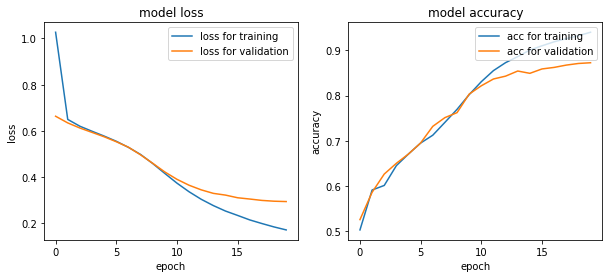

In [16]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axR.plot(history.history['accuracy'],label="acc for training")
axR.plot(history.history['val_accuracy'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='upper right')
plt.axes(axR)

axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
plt.axes(axL)

# モデルの評価

訓練したモデルの性能を評価していきます。

In [27]:
results = model.evaluate(test_reviews.batch(512), verbose=1)
print("\n")

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

     49/Unknown - 2s 35ms/step - loss: 0.3095 - accuracy: 0.8641

loss: 0.310
accuracy: 0.864


In [86]:
predictions = model.predict(test_reviews.batch(5))

In [115]:
test = next(iter(test_reviews.batch(20)));

In [116]:
predictions = model.predict(test)

In [117]:
print('Prediction of positive or negative on test review #1')
first_test_data_tensor = next(iter(test_reviews));
first_test_data_numpy  = first_test_data_tensor[0].numpy();
first_test_label_numpy  = first_test_data_tensor[1].numpy();
print("\n Review : \n" , first_test_data_numpy)
print("\n Label : \n" , first_test_label_numpy)


print(test[1])

for i in range(20):
    print(predictions[i])

Prediction of positive or negative on test review #1

 Review : 
 b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time ha